### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib.colors import ListedColormap


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading Data

In [2]:
image1 = pd.read_fwf("image1.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])
image2 = pd.read_fwf("image2.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])
image3 = pd.read_fwf("image3.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])

In [3]:
complete = image1.append(image2).append(image3)
complete = complete.loc[complete.loc[:,"label"]!=0,:] #exclude pixels without expert labels

### Splitting Data

In [4]:
block1 = complete.loc[complete.loc[:,'x']<147,:]
block2 = complete.loc[(complete.loc[:,'x']>=147) & (complete.loc[:,'x']<221),:]
block3 = complete.loc[(complete.loc[:,'x']>=221) & (complete.loc[:,'x']<309),:]
block4 = complete.loc[complete.loc[:,'x']>309,:]

In [5]:
train1, test1 = train_test_split(block1,train_size=int(np.ceil(block1.shape[0]*7/10)),shuffle=True,random_state=42)
train2, test2 = train_test_split(block2,train_size=int(np.ceil(block2.shape[0]*7/10)),shuffle=True,random_state=42)
train3, test3 = train_test_split(block3,train_size=int(np.ceil(block3.shape[0]*7/10)),shuffle=True,random_state=42)
train4, test4 = train_test_split(block4,train_size=int(np.ceil(block4.shape[0]*7/10)),shuffle=True,random_state=42)

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
train1, val1 = train_test_split(train1,train_size=int(np.ceil(train1.shape[0]*5/7)),shuffle=True,random_state=42)
train2, val2 = train_test_split(train2,train_size=int(np.ceil(train2.shape[0]*5/7)),shuffle=True,random_state=42)
train3, val3 = train_test_split(train3,train_size=int(np.ceil(train3.shape[0]*5/7)),shuffle=True,random_state=42)
train4, val4 = train_test_split(train4,train_size=int(np.ceil(train4.shape[0]*5/7)),shuffle=True,random_state=42)

In [7]:
train = (
    train1.
    append(train2).
    append(train3).
    append(train4)
)

val = (
    val1.
    append(val2).
    append(val3).
    append(val4)
)

test = (
    test1.
    append(test2).
    append(test3).
    append(test4)
)

train_val = train.append(val)

### CVgeneric

In [12]:
def CVgeneric(features, labels, K, classifier, loss):
    errors = []
    folds = KFold(K)
    for train_idx, val_idx in folds.split(features):
        train_features, train_labels = features.iloc[train_idx,:], labels.iloc[train_idx]
        val_features, val_labels = features.iloc[val_idx,:], labels.iloc[val_idx]
        
        model = classifier.fit(train_features.loc[:,['NDAI','AF','AN']], train_labels)
        predictions = model.predict(val_features.loc[:,['NDAI','AF','AN']])
        
        errors.append(loss(predictions, val_labels))
    return errors        

### Loss Functions / Metrics

In [13]:
def accuracy(fitted, actual):
    return sum(fitted==actual)/len(actual)

In [14]:
def tpr(fitted, actual):
    true_positive = sum((fitted == actual) & (actual == -1))
    false_negative = sum((fitted != actual) & (actual == -1))
    return true_positive/(true_positive+false_negative)

In [15]:
def fpr(fitted, actual):
    false_positive = sum((fitted != actual) & (actual == 1))
    true_negative = sum((fitted == actual) & (actual == 1))
    return false_positive/(false_positive+true_negative)

### Features

In [10]:
features = ['NDAI','AF','AN']

### Logistic Regression

In [17]:
logistic_model=LogisticRegression().fit(train_val.loc[:,features],train_val.loc[:,'label'])

In [18]:
logistic_score = logistic_model.decision_function(train_val.loc[:,features])

In [19]:
logistic_fpr, logistic_tpr, logistic_thresholds = roc_curve(train_val.loc[:, 'label'], logistic_score)
logistic_roc_auc = auc(logistic_fpr, logistic_tpr)
    
#logistic_fpr["micro"], logistic_tpr["micro"], _ = roc_curve(val.loc[:, 'label'].ravel(), logistic_score.ravel())
#logistic_roc_auc["micro"] = auc(logistic_fpr["micro"], logistic_tpr["micro"])

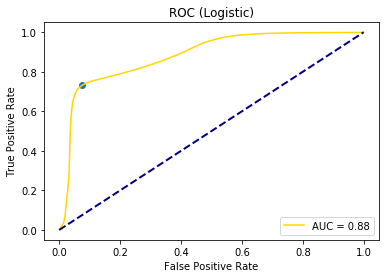

In [154]:
plt.plot(logistic_fpr,logistic_tpr,color='gold', label='AUC = %0.2f' % logistic_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(x=logistic_fpr[np.argmax(logistic_tpr-logistic_fpr)],
           y=logistic_tpr[np.argmax(logistic_tpr-logistic_fpr)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logistic)')
plt.legend(loc='lower right')
plt.savefig('ROC_Logistic (X-Split)')
plt.show()

In [21]:
logistic_cutoff = logistic_thresholds[np.argmax(logistic_tpr-logistic_fpr)]
logistic_cutoff

1.2208952478447799

In [24]:
pd.DataFrame({'Fold': np.arange(1,6), 'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,LogisticRegression(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.851690
2,0.819034
3,0.815442
4,0.826339
5,0.810925


### K-Nearest Neighbors

In [20]:
pd.DataFrame({
    'Fold': np.arange(1,6),
    'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,KNeighborsClassifier(8),accuracy)
}).set_index('Fold')

,Accuracy
Fold,
1,0.924655
2,0.880241
3,0.927273
4,0.931929
5,0.914928


In [26]:
TPRs = []
for i in np.arange(1,21):
    tpr_dummy = CVgeneric(train_val.loc[:,['NDAI','AF','AN']],train_val.loc[:,'label'],5,KNeighborsClassifier(i),tpr)
    TPRs.append(tpr_dummy)

k = 1 ; [0.6437064370643707, 0.7670789504103572, 0.8696981276270539, 0.7384774728120145, 0.8236035808851343]
k = 2 ; [0.7761377613776138, 0.8508842908334296, 0.9282893898866387, 0.8463663041601933, 0.8952212835707981]
k = 3 ; [0.6564165641656416, 0.789388509998844, 0.8751751369252324, 0.7510788883134818, 0.8374732064052453]
k = 4 ; [0.7349323493234933, 0.8343544098948098, 0.9123678512291428, 0.8154669428620749, 0.8765603328710125]
k = 5 ; [0.6621566215662157, 0.8000231187145995, 0.8858744109030696, 0.7579837735197652, 0.8381036439288867]
k = 6 ; [0.7193521935219352, 0.8298462605479136, 0.9081645650235639, 0.8020024167098222, 0.8691211700920439]
k = 7 ; [0.6611316113161132, 0.8040688937695064, 0.8904598140364285, 0.7598826169514932, 0.8456688942125835]
k = 8 ; [0.7082820828208282, 0.8278811698069587, 0.9075277034772641, 0.7954427757638529, 0.8673559450258479]
k = 9 ; [0.6678966789667896, 0.80695873309444, 0.8910966755827283, 0.7605731054721215, 0.8442819316605724]
k = 10 ; [0.7023370233

In [28]:
FPRs = []
for i in np.arange(1,21):
    fpr_dummy = CVgeneric(train.loc[:,['NDAI','AF','AN']],train.loc[:,'label'],5,KNeighborsClassifier(i),fpr)
    FPRs.append(fpr_dummy)

k = 1 ; [0.05657474931631723, 0.08487109017144352, 0.09489851892484914, 0.08094919786096257, 0.060970347080944454]
k = 2 ; [0.09873518687329079, 0.12112288967412642, 0.1452276467361492, 0.12433155080213903, 0.09808273226064977]
k = 3 ; [0.03230401093892434, 0.07440125638005497, 0.08358475041140977, 0.06631016042780749, 0.05055175389926638]
k = 4 ; [0.047686873290793075, 0.09049862583431488, 0.10744651673066374, 0.08897058823529412, 0.06935454041057888]
k = 5 ; [0.02643573381950775, 0.07296165423373904, 0.07878496982995063, 0.06203208556149733, 0.046914493557733805]
k = 6 ; [0.035323609845031904, 0.08519827247742442, 0.0968184311574328, 0.07606951871657754, 0.060538807718389744]
k = 7 ; [0.024669553327256153, 0.07355058238450464, 0.07672792100932528, 0.05962566844919786, 0.04407866346094569]
k = 8 ; [0.030765724703737465, 0.08199188587881168, 0.08865880416895228, 0.07212566844919786, 0.0533875839960545]
k = 9 ; [0.023587055606198722, 0.07335427300091611, 0.07521941854086671, 0.059157754

In [45]:
TPR_avg = pd.Series([np.mean(errors) for errors in TPRs])
FPR_avg = pd.Series([np.mean(errors) for errors in FPRs])

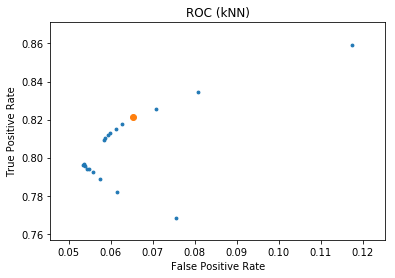

Optimal choice: k = 8


In [155]:
plt.scatter(x=FPR_avg, y=TPR_avg, s=8)
plt.scatter(x=FPR_avg[(TPR_avg-FPR_avg).idxmax()], y=TPR_avg[(TPR_avg-FPR_avg).idxmax()])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (kNN)')
plt.savefig('ROC_kNN (X-Split)')
plt.show()
print("Optimal choice: k = 8")

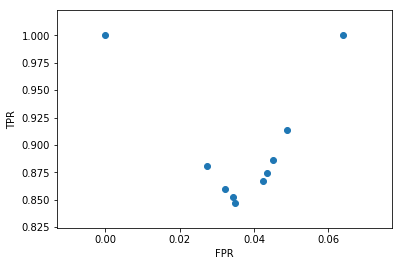

In [131]:
plt.scatter(y=kNN_TPRs, x=kNN_FPRs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [64]:
final_kNN = KNeighborsClassifier(8)
final_kNN.fit(train_val.loc[:,features],train_val.loc[:,'label'])
final_kNN_predictions = final_kNN.predict(test.loc[:,features])

accuracy(final_kNN_predictions, test.loc[:,'label'])

0.921883549518813

#### Predicted Labels

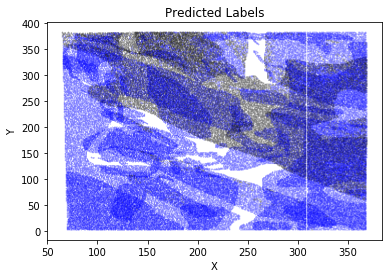

           Blue: Clouds        Black: Surface


In [156]:
plt.scatter(train_val.loc[:,'x'],train_val.loc[:,'y'],
            s=0.01, c=final_kNN.predict(train_val.loc[:,['NDAI','AF','AN']]),
            cmap=ListedColormap(['black','blue']))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted Labels')
plt.savefig('Predicted (X-Split)')
plt.show()
print("           Blue: Clouds        Black: Surface")

#### Actual Labels

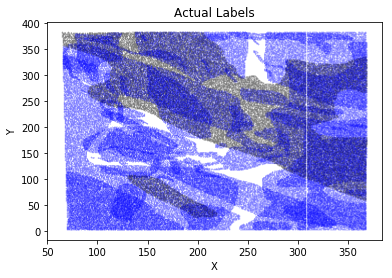

           Blue: Clouds        Black: Surface


In [157]:
plt.scatter(train_val.loc[:,'x'],train_val.loc[:,'y'],
            s=0.01, c=train_val.loc[:,'label'],cmap=ListedColormap(['black','blue']))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual Labels')
plt.savefig('Actual (X-Split)')
plt.show()
print("           Blue: Clouds        Black: Surface")

#### Mislabeled

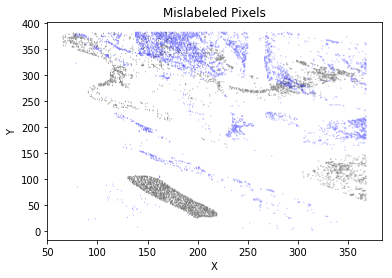

           Blue: Clouds        Black: Surface


In [158]:
plt.scatter(x=train_val.loc[train_val.loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'x'],
            y=train_val.loc[train_val.loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'y'],
            c=train_val.loc[train.append(val).loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'label'],
            s=0.01,
            cmap=ListedColormap(['black', 'blue']))
plt.title('Mislabeled Pixels')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('Mislabeled (X-Split)')
plt.show()
print("           Blue: Clouds        Black: Surface")

### LDA / QDA

In [17]:
pd.DataFrame({
    'Fold': np.arange(1,6), 
    'Accuracy': CVgeneric(train.append(val).loc[:,features],train.append(val).loc[:,'label'],5,QuadraticDiscriminantAnalysis(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.879621
2,0.802966
3,0.723301
4,0.764371
5,0.737232


In [18]:
pd.DataFrame({
    'Fold': np.arange(1,6), 
    'Accuracy': CVgeneric(train.append(val).loc[:,features],train.append(val).loc[:,'label'],5,LinearDiscriminantAnalysis(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.845724
2,0.783862
3,0.776372
4,0.773165
5,0.768095


In [80]:
LDA = LinearDiscriminantAnalysis().fit(train_val.loc[:,features], train_val.loc[:,'label'])
LDA_decision = LDA.decision_function(train_val.loc[:,features])

QDA = QuadraticDiscriminantAnalysis().fit(train_val.loc[:,features], train_val.loc[:,'label'])
QDA_decision = QDA.decision_function(train_val.loc[:,features])

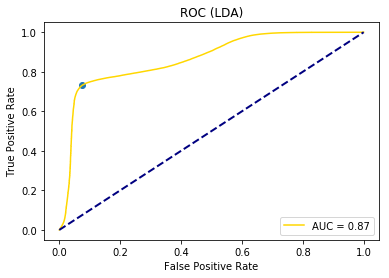

               Optimal Cutoff: C = 1.246


In [159]:
LDA_fpr, LDA_tpr, LDA_thresholds = roc_curve(train_val.loc[:,'label'], LDA_decision)
LDA_roc_auc = auc(LDA_fpr, LDA_tpr)

plt.plot(LDA_fpr, LDA_tpr, color='gold', label='AUC = %0.2f' % LDA_roc_auc)
plt.scatter(x=LDA_fpr[np.argmax(LDA_tpr-LDA_fpr)],
           y=LDA_tpr[np.argmax(LDA_tpr-LDA_fpr)])
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (LDA)')
plt.legend(loc='lower right')
plt.savefig('ROC_LDA (X-Split)')
plt.show()
print("               Optimal Cutoff: C = " + str(round(LDA_thresholds[np.argmax(LDA_tpr-LDA_fpr)],3)))

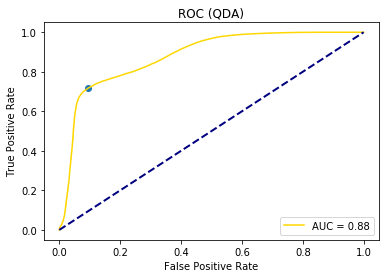

               Optimal Cutoff: C = 0.819


In [160]:
QDA_fpr, QDA_tpr, QDA_thresholds = roc_curve(train_val.loc[:,'label'], QDA_decision)
QDA_roc_auc = auc(QDA_fpr, QDA_tpr)

plt.plot(QDA_fpr, QDA_tpr, color='gold', label='AUC = %0.2f' % QDA_roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.scatter(x=QDA_fpr[np.argmax(QDA_tpr-QDA_fpr)],
           y=QDA_tpr[np.argmax(QDA_tpr-QDA_fpr)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (QDA)')
plt.legend(loc='lower right')
plt.savefig('ROC_QDA (X-Split)')
plt.show()
print("               Optimal Cutoff: C = " + str(round(QDA_thresholds[np.argmax(QDA_tpr-QDA_fpr)],3)))

### Random Forest

In [151]:
pd.DataFrame({
    'Fold': np.arange(1,6),
    'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=80),accuracy)
}
).set_index('Fold')

,Accuracy
Fold,
1,0.916483
2,0.878655
3,0.924446
4,0.928446
5,0.910618


In [143]:
depths = np.arange(10,101,10)

In [129]:
RF_TPR = []
RF_FPR = []
RF_acc = []
for i in depths:
    RF_TPR.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),tpr))))
    RF_FPR.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),fpr))))
    RF_acc.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),accuracy))))

In [144]:
RF_TPR = pd.Series(RF_TPR)
RF_FPR = pd.Series(RF_FPR)

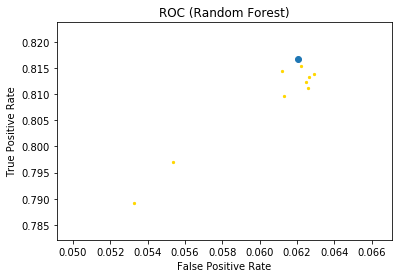

               Optimal Max Depth: depth = 80


In [161]:
plt.scatter(RF_FPR, RF_TPR, color='gold',s=5)
plt.scatter(RF_FPR[(RF_TPR-RF_FPR).idxmax()], RF_TPR[(RF_TPR-RF_FPR).idxmax()])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
#plt.legend(loc='lower right')
plt.savefig('ROC_RF (X-Split)')
plt.show()
print("               Optimal Max Depth: depth = " + str(depths[(RF_TPR-RF_FPR).idxmax()]))

In [153]:
final_RF = RandomForestClassifier(max_depth=40).fit(train_val.loc[:,features],train_val.loc[:,'label'])
final_RF_predictions = final_RF.predict(test.loc[:,features])

accuracy(final_RF_predictions, test.loc[:,'label'])

0.918568347870868